In [554]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230710_Axial_z2_Data'
dataname = data+'_MMF'+'A11'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:12]
SensorData1 = SD1

In [555]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
200182,44,40,54,35,42,44,53,47.64,-4262.26,140,0,5.6
62550,50,47,49,46,44,36,43,72.62,-1865.57,42,0,7.2
206680,38,36,51,37,39,42,49,62.68,-4620.85,144,0,8.0
158784,50,40,41,37,39,37,48,90.84,-3013.77,110,0,8.0
219531,42,41,51,37,37,42,51,34.35,-5072.61,154,0,4.8


In [556]:
# data = '230703_Axial_z2_Data_2'
# dataname = data+'_02'
# filename = 'myData/'+data+'.csv'
# SD2 = pd.read_csv(filename)
# SD2=SD2.iloc[:,:28]
# SensorData2 = SD2
# SD2['z'] += 550
# SD2['z'] /= 5
# SD2

In [557]:
# SDreal = pd.concat([SD1, SD2])

In [558]:
SDreal = SD1

In [559]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.0,226477.000000
mean,48.346185,44.993116,48.101167,40.125554,44.090053,43.143569,47.287703,42.117940,-2505.894559,78.630024,0.0,4.797753
std,84.095088,59.711839,78.833617,66.752353,78.681733,89.272349,66.636892,24.206043,1448.535114,46.262884,0.0,2.066331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,-5209.280000,0.000000,0.0,1.600000
25%,46.000000,43.000000,46.000000,37.000000,41.000000,40.000000,45.000000,23.220000,-3288.870000,38.000000,0.0,3.200000
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,48.000000,42.420000,-2819.360000,78.000000,0.0,4.800000
75%,50.000000,47.000000,50.000000,43.000000,46.000000,45.000000,50.000000,60.550000,-1591.520000,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,103.350000,124.190000,158.000000,0.0,8.000000


In [560]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 100)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*3]
SDreal = SDreal[SDreal["z"] <= 160]
SDreal = SDreal[SDreal["z"] >= 0]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.000000,174569.0,174569.000000
mean,47.575692,44.628365,47.119643,39.389273,43.389044,42.171497,46.291358,50.797009,-2510.567380,78.670325,0.0,5.600032
std,3.990995,4.633284,3.947540,4.449414,3.944625,3.716325,4.377339,18.604661,1447.209116,46.251423,0.0,1.600079
min,12.000000,26.000000,28.000000,20.000000,22.000000,27.000000,27.000000,6.590000,-5208.490000,0.000000,0.0,3.200000
25%,46.000000,42.000000,45.000000,37.000000,41.000000,40.000000,44.000000,35.680000,-3295.810000,38.000000,0.0,4.000000
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,47.000000,49.960000,-2819.090000,78.000000,0.0,5.600000
75%,50.000000,48.000000,50.000000,43.000000,46.000000,44.000000,49.000000,65.120000,-1619.300000,118.000000,0.0,7.200000
max,62.000000,71.000000,80.000000,64.000000,60.000000,57.000000,60.000000,103.350000,124.010000,158.000000,0.0,8.000000


In [561]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
651,43,39,45,34,52,43,49,-0.872613,4.75,-0.995827,0,-1.000013
652,43,39,45,34,52,43,49,-0.870339,4.75,-0.995827,0,-1.000013
653,43,39,47,34,53,43,49,-0.871993,4.75,-0.995827,0,-1.000013
654,45,39,49,34,53,43,49,-0.872406,4.75,-0.995827,0,-1.000013
655,45,39,49,34,53,43,49,-0.873646,4.75,-0.995827,0,-1.000013
...,...,...,...,...,...,...,...,...,...,...,...,...
226472,48,44,51,41,41,39,52,-0.142559,-4962.83,1.004173,0,0.999987
226473,48,44,51,41,41,41,52,-0.143593,-4962.83,1.004173,0,0.999987
226474,48,46,51,42,41,41,52,-0.143386,-4962.83,1.004173,0,0.999987
226475,48,46,53,42,41,42,52,-0.142972,-4962.83,1.004173,0,0.999987


In [562]:
SDy = SDreal.iloc[:,[7,9]]
SDy.describe()

,Force,z
count,1.745690e+05,1.745690e+05
mean,-1.422123e-14,-5.242818e-13
std,3.845527e-01,5.854611e-01
min,-9.137455e-01,-9.958269e-01
25%,-3.124640e-01,-5.148142e-01
50%,-1.730073e-02,-8.485129e-03
75%,2.960519e-01,4.978440e-01
max,1.086254e+00,1.004173e+00


In [563]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# SDreal.hist(bins=50, figsize=(20,15))
# plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/'+dataname+'_hist230320.png')
# plt.show()

In [564]:
X = SDreal.iloc[:,:7]
y = SDreal.iloc[:,[7,9]]

In [565]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06
651,43,39,45,34,52,43,49
652,43,39,45,34,52,43,49
653,43,39,47,34,53,43,49
654,45,39,49,34,53,43,49
655,45,39,49,34,53,43,49
...,...,...,...,...,...,...,...
226472,48,44,51,41,41,39,52
226473,48,44,51,41,41,41,52
226474,48,46,51,42,41,41,52
226475,48,46,53,42,41,42,52


In [566]:
y.sample(5)

,Force,z
161089,0.297912,0.421895
183718,0.225775,0.624426
6804,-0.762030,-0.945194
166388,0.191257,0.472528
160828,0.144750,0.421895


In [567]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [568]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  138258 ea 79 %    X_valid:  34565 ea 19 %    X_test:  1746 ea 1 %


In [569]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [570]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230710_Axial_z2_Data_MMFA11_SS.pkl']

In [571]:
from tensorflow import keras
model = keras.models.Sequential([ 
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 128)               1024      
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dense_105 (Dense)           (None, 32)                2080      
                                                                 
 dense_106 (Dense)           (None, 16)                528       
                                                                 
 dense_107 (Dense)           (None, 8)                 136       
                                                                 
 dense_108 (Dense)           (None, 2)                 18        
                                                                 
Total params: 12,042
Trainable params: 12,042
Non-tra

## Callback (best, early stopping, tensorboard)

In [572]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [573]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [574]:
dataname

'230710_Axial_z2_Data_MMFA11'

In [575]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
4321/4321 [==============================] - 9s 2ms/step - loss: 0.0645 - val_loss: 0.0643
Epoch 2/300
4321/4321 [==============================] - 8s 2ms/step - loss: 0.0573 - val_loss: 0.0572
Epoch 3/300
4321/4321 [==============================] - 9s 2ms/step - loss: 0.0561 - val_loss: 0.0588
Epoch 4/300
4321/4321 [==============================] - 8s 2ms/step - loss: 0.0558 - val_loss: 0.0555
Epoch 5/300
4321/4321 [==============================] - 8s 2ms/step - loss: 0.0550 - val_loss: 0.0556
Epoch 6/300
4321/4321 [==============================] - 8s 2ms/step - loss: 0.0546 - val_loss: 0.0560
Epoch 7/300
4321/4321 [==============================] - 8s 2ms/step - loss: 0.0545 - val_loss: 0.0555
Epoch 8/300
4321/4321 [==============================] - 9s 2ms/step - loss: 0.0544 - val_loss: 0.0575
Epoch 9/300
4321/4321 [==============================] - 9s 2ms/step - loss: 0.0543 - val_loss: 0.0615
Epoch 10/300
4321/4321 [==============================] - 9s 2ms/step - l

In [576]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [577]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [578]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

1081/1081 [==============================] - 1s 803us/step


,force,z
count,34565.000000,34565.000000
mean,-0.004358,-0.003565
std,0.383580,0.585285
min,-0.912712,-0.995827
25%,-0.317838,-0.514814
50%,-0.024949,-0.008485
75%,0.293985,0.497844
max,1.053390,1.004173


In [579]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
89.47% force
87.93% z


,force,z,valid_force,valid_z
force,1.000000,0.193642,0.894749,0.148286
z,0.193642,1.000000,0.183288,0.879277
valid_force,0.894749,0.183288,1.000000,0.197654
valid_z,0.148286,0.879277,0.197654,1.000000


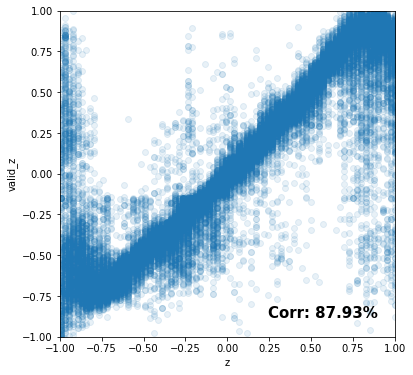

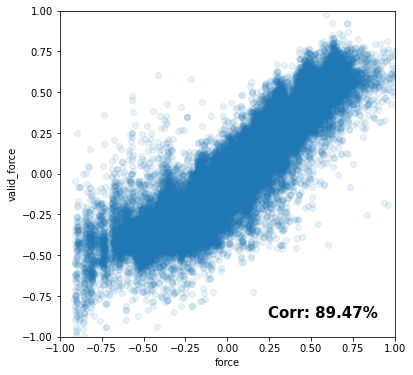

In [580]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
